# Implementation of "Graph Sparsification by Effective Resistances" by Spielman and Srivastava

## See:
@article{DBLP:journals/corr/abs-0803-0929,
  author    = {Daniel A. Spielman and
               Nikhil Srivastava},
  title     = {Graph Sparsification by Effective Resistances},
  journal   = {CoRR},
  volume    = {abs/0803.0929},
  year      = {2008},
  url       = {http://arxiv.org/abs/0803.0929},
  archivePrefix = {arXiv},
  eprint    = {0803.0929},
  timestamp = {Mon, 13 Aug 2018 16:46:14 +0200},
  biburl    = {https://dblp.org/rec/bib/journals/corr/abs-0803-0929},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}

This implementation was done for the seminar "Graph Sparsification" at TUM.

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
def construct_matrices(A):
    """ Enumerates the edges in the graph and constructs the matrices neccessary for the algorithm.
    
    Parameters:
    -----------
    A : sp.csr_matrix, shape [N, N]
        The graph adjacency matrix.
    
    Returns:
    --------
    L : sp.csr_matrix, shape [N, N]
        The graph laplacian, unnormalized.
    W_sqrt : sp.coo_matrix, shape [e, e]
        Diagonal matrix containing the square root of weights of each edge.
    B : sp.coo_matrix, shape [e, N]
        Signed vertex incidence matrix.
    edges : tuple
        A tuple of lists containing the row and column indices of the edges.
    """
    L = sp.csgraph.laplacian(A)
    rows, cols = A.nonzero()
    weights = np.sqrt(np.array(A[rows, cols].tolist()))
    W_sqrt = sp.diags(weights, [0])
    # Construct signed edge incidence matrix
    num_vertices = A.shape[0]
    num_edges = W_sqrt.shape[0]
    assert(num_edges == len(rows) and num_edges == len(cols))
    B = sp.coo_matrix((
        ([1] * num_edges) + ([-1] * num_edges),
        (list(range(num_edges)) * 2, list(rows) + list(cols))
    ), shape=[num_edges, num_vertices])
    return L.tocsr(), W_sqrt, B, (rows, cols)

In [3]:
def compute_Z(L, W_sqrt, B, epsilon=1e-1, eta=1e-3, max_iters=1000, convergence_after = 10,
                                    tolerance=1e-2, log_every=10, compute_exact_loss=False):
    """ Computes the Z matrix using gradient descent.
    
    Parameters:
    -----------
    L : sp.csr_matrix, shape [N, N]
        The graph laplacian, unnormalized.
    W_sqrt : sp.coo_matrix, shape [e, e]
        Diagonal matrix containing the square root of weights of each edge.
    B : sp.coo_matrix, shape [e, N]
        Signed vertex incidence matrix.
    epsilon : float
        Tolerance for deviations w.r.t. spectral norm of the sparsifier. Smaller epsilon lead to a higher
        dimensionality of the Z matrix.
    eta : float
        Step size for the gradient descent.
    max_iters : int
        Maximum number of iterations.
    convergence_after : int
        If the loss did not decrease significantly for this amount of iterations, the gradient descent will abort.
    tolerance : float
        The minimum amount of energy decrease that is expected for iterations. If for a certain number of iterations
        no overall energy decrease is detected, the gradient descent will abort.
    log_every : int
        Log the loss after each log_every iterations.
    compute_exact_loss : bool
        Only for debugging. If set it computes the actual pseudo inverse without down-projection and checks if
        the pairwise distances in Z's columns are the same with respect to the forbenius norm.
        
    Returns:
    --------
    Z : ndarray, shape [k, N]
        Matrix from which to efficiently compute approximate resistances.
    """
    k = int(np.ceil(np.log(B.shape[1] / epsilon**2)))
    # Compute the random projection matrix
    Q = (2 * np.random.randint(2, size=(k, B.shape[0])) - 1).astype(np.float)
    Q *= 1 / np.sqrt(k)
    Y = W_sqrt.dot(B).tocsr()
    Y_red = sp.csr_matrix.dot(Q, Y)
    
    if compute_exact_loss:
        # Use exact effective resistances to track actual similarity of the pairwise distances
        L_inv = np.linalg.pinv(L.todense())
        Z_gnd = sp.csr_matrix.dot(Y, L_inv)
        pairwise_dist_gnd = Z_gnd.T.dot(Z_gnd)
    
    # Use gradient descent to solve for Z
    Z = np.random.randn(k, L.shape[1])
    best_loss = np.inf
    best_iter = np.inf
    for it in range(max_iters):
        residual = Y_red - sp.csr_matrix.dot(Z, L)
        loss = np.linalg.norm(residual)
        if it % log_every == 0: 
            print(f'Loss before iteration {it}: {loss}')
            if compute_exact_loss:
                pairwise_dist = Z.T.dot(Z)
                exact_loss = np.linalg.norm(pairwise_dist - pairwise_dist_gnd)
                print(f'Loss w.r.t. exact pairwise distances {exact_loss}')
                
        if loss + tolerance < best_loss:
            best_loss = loss
            best_iter = it
        elif it > best_iter + convergence_after:
            # No improvement for 10 iterations
            print(f'Convergence after {it - 1} iterations.')
            break
        
        Z += eta * L.dot(residual.T).T
    return Z
    

In [4]:
def compute_effective_resistances(Z, edges):
    """ Computes the effective resistance for each edge in the graph.
    
    Paramters:
    ----------
    Z : ndarray, shape [k, N]
        Matrix from which to efficiently compute approximate effective resistances.
    edges : tuple
        A tuple of lists indicating the row and column indices of edges.
        
    Returns:
    --------
    R : ndarray, shape [e]
        Effective resistances for each edge.
    """
    rows, cols = edges
    assert(len(rows) == len(cols))
    R = []
    # Compute pairwise distances
    for i, j in zip(rows, cols):
        R.append(np.linalg.norm(Z[:, i] - Z[:, j]) ** 2)
    return np.array(R)

In [5]:
def sparsify(A, q, R, edges, prevent_vertex_blow_up=False):
    """ Spamples a sparsifier of the graph represented by an adjacency matrix.
    
    Paramters:
    ----------
    A : sp.csr_matrix
        The adjacency matrix of the graph.
    q : int
        The number of samples for the sparsifier.
    R : ndarray, shape [e]
        Effective resistances (approximate) for each edge.
    edges : tuple
        A tuple of lists indicating the row and column indices of edges.
    prevent_vertex_blow_up : bool
        If the probabilities will be tweaked in order to ensure that the vertices are not
        blown up too much. Note that this will only guarantee a spectral closeness up
        to a factor of 2 * epsilon.
        
    Returns:
    --------
    B : sp.csr_matrix
        The adjacency matrix of the sparsified graph with at most q edges.
    """
    rows, cols = edges
    weights = np.array(A[rows, cols].tolist())[0, :]
    probs = weights * R
    probs /= sum(probs)
    probs = probs.reshape((probs.shape[0], 1))
    if prevent_vertex_blow_up: # Proabilities do not sum up to one? But also in the paper I guess...
        degrees = A.sum(1)[np.array(edges)].squeeze().T
        mins = 1 / np.min(degrees, axis=1) / A.shape[0]
        probs += mins
        probs /= 2
    B = sp.lil_matrix(A.shape)
    sampled = np.random.choice(probs.shape[0], q, p=probs.ravel())
    for idx in sampled:
        i, j = rows[idx], cols[idx]
        B[i, j] += weights[idx] / q / probs[idx]
    return B.tocsr()

In [6]:
def spectral_sparsify(A, q=None, epsilon=1e-1, eta=1e-3, max_iters=1000, convergence_after=100,
                                    tolerance=1e-2, log_every=10, prevent_vertex_blow_up=False):
    """ Computes a spectral sparsifier of the graph given by an adjacency matrix.
    
    Parameters:
    ----------
    A : sp.csr_matrix, shape [N, N]
        The adjacency matrix of the graph.
    q : int or None
        The number of samples for the sparsifier. If None q will be set to N * log(N) / (epsilon * 2)
    epsilon : float
        The desired spectral similarity of the sparsifier.
    eta : float
        Step size for the gradient descent when computing resistances.
    max_iters : int
        Maximum number of iterations when computing resistances.
    convergence_after : int
        If the loss did not decrease significantly for this amount of iterations, the gradient descent will abort.
    tolerance : float
        The minimum amount of energy decrease that is expected for iterations. If for a certain number of iterations
        no overall energy decrease is detected, the gradient descent will abort.
    log_every : int
        Log the loss after each log_every iterations when computing resistances.
    prevent_vertex_blow_up : bool
        If the probabilities will be tweaked in order to ensure that the vertices are not
        blown up too much. Note that this will only guarantee a spectral closeness up
        to a factor of 2 * epsilon.
    
    Returns:
    --------
    H : sp.csr_matrix, shape [N, N]
        Sparsified graph with at most q edges.
    """
    if q is None:
        q = int(np.ceil(A.shape[0] * np.log(A.shape[0]) / (epsilon ** 2)))
    L, W_sqrt, B, edges = construct_matrices(A)
    Z = compute_Z(L, W_sqrt, B, epsilon=epsilon, log_every=log_every, max_iters=max_iters, convergence_after=convergence_after, eta=eta, tolerance=tolerance, compute_exact_loss=False)
    R = compute_effective_resistances(Z, edges)
    return sparsify(A, q, R, edges, prevent_vertex_blow_up=prevent_vertex_blow_up)

In [7]:
def visualize_graph(A, plot_labels=True):
    rows, cols = A.nonzero()
    edges = list(zip(rows.tolist(), cols.tolist()))
    gr = nx.Graph()
    gr.add_edges_from(edges)
    graph_pos=nx.random_layout(gr)
    nx.draw_networkx_nodes(gr, graph_pos, node_size=2)
    nx.draw_networkx_edges(gr, graph_pos, edge_size=1)
    weights = A[rows, cols].tolist()[0]
    if plot_labels: nx.draw_networkx_edge_labels(gr, graph_pos, edge_labels=dict(zip(edges, weights)))
    plt.show()


In [8]:
# Create an artificial small graph for testing
# Construct a random adjacency matrix for testing
np.random.seed(1337)
n = 500
m = n * n // 8
A = sp.coo_matrix((np.abs(np.random.randn(m)), (np.random.randint(n, size=m), np.random.randint(n, size=m))), shape=[n, n])
A = A.tocsr()
A = A + A.T
m = A.nnz

In [9]:
# Create the complete graph with n vertices
n = 1000
A = sp.csr_matrix(np.ones([n, n]))
m = A.nnz
epsilon = 3e-1
n, m

(1000, 1000000)

In [10]:
# Uncomment only if A has few edges
#visualize_graph(A, plot_labels=False)

In [11]:
B = spectral_sparsify(A, epsilon=epsilon, log_every=100, convergence_after=100, eta=1e-6, max_iters=100000, prevent_vertex_blow_up=True)
print(f'Sparsified graph has {B.nnz} edges.')
#visualize_graph(B, plot_labels=False)

Loss before iteration 0: 99601.92028899242
Loss before iteration 100: 1.6293694187463441e-12
Convergence after 101 iterations.
Sparsified graph has 73833 edges.


In [12]:
def spectral_closeness(L_A, L_X, samples=10000):
    """ Checks the spectral closeness for random vectors.
    
    Parameters:
    -----------
    L_A : sp.csr_matrix
        Laplacian of the original graph.
    L_A : sp.csr_matrix
        Laplacian of the sparsifier.
    samples : int
        The number of random vectors to sample.
        
    Returns:
    --------
    closeness : ndarray, [samples]
        The closeness of the spectral forms w.r.t. to each sample.
    """
    results = []
    for _ in range(samples):
        x = np.random.rand(L_A.shape[0])
        energy = sp.csr_matrix.dot(x.T, L_A).dot(x)
        energy_approx = sp.csr_matrix.dot(x.T, L_X).dot(x)
        results.append(np.abs((energy_approx / energy) - 1))
    return np.array(results)
    

In [13]:
# Check the spectral closeness of A and its sparsifier
scores = spectral_closeness(sp.csgraph.laplacian(A), sp.csgraph.laplacian(B))
rate = np.sum((scores <= epsilon).astype(np.int)) / scores.shape[0]  * 100
print(f'{rate} % of samples deviated at most {epsilon} from the original graph w.r.t. to their laplacians.')

100.0 % of samples deviated at most 0.3 from the original graph w.r.t. to their laplacians.


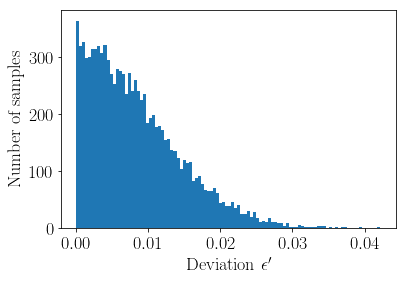

In [14]:
# Make plots for the paper
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=18)

f = plt.figure()
plt.hist(scores, bins=100)
plt.xlabel(r'Deviation $\epsilon^\prime$')
plt.ylabel(r'Number of samples')
plt.title('')
f.savefig("../paper/spectral.pdf", bbox_inches='tight', format='pdf')

In [15]:
# Compare a random sparsifier with same amount of edges
def random_sparsifier(A, q):
    rows, cols = A.nonzero()
    weights = np.array(A[rows, cols].tolist())[0, :]
    B = sp.lil_matrix(A.shape)
    sampled = np.random.choice(len(rows), q, replace=False)
    for idx in sampled:
        i, j = rows[idx], cols[idx]
        B[i, j] += weights[idx]
    return B.tocsr()

In [ ]:
B_rnd = random_sparsifier(A, int(np.ceil(A.shape[0] * np.log(A.shape[0]) / (epsilon ** 2))))
scores_rnd = spectral_closeness(sp.csgraph.laplacian(A), sp.csgraph.laplacian(B_rnd))
rate_rnd = np.sum((scores_rnd <= epsilon).astype(np.int)) / scores_rnd.shape[0]  * 100
print(f'{rate_rnd} % of samples deviated at most {epsilon} from the original graph w.r.t. to their laplacians.')

In [ ]:
# Make plots for the paper
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=18)

f = plt.figure()
plt.hist(scores_rnd, bins=100)
plt.xlabel(r'Deviation $\epsilon^\prime$')
plt.ylabel(r'Number of samples')
plt.title('')
f.savefig("../paper/random.pdf", bbox_inches='tight', format='pdf')